## Calculate the SVF from Ground DSM using PyCUDA
This script will use the shadow casting algorithm to calculate the sky view factors. The method based on the Ray-tracing has been implemented. Let's compare the dfficiency of these methods later. 

First version Dec 22, 2020, by Xiaojiang Li, Temple University

Last modified Dec 30, 2020

## Calculate the svf based on the ground-dsm using the shadow casting method

In [25]:
import os, os.path
import rasterio as rio
import numpy as np


demroot = '/drive2/researchProj/gpu-climate/spatial-data/ground_dsm'


for file in os.listdir(demroot):
    demfile = os.path.join(demroot, file)
    #demfile = r'/drive2/thermal-env/data/philadelphia/tiles1000/row40-col24.tif'
    lu_dataset = rio.open(demfile)
    
    lu_bounds = lu_dataset.bounds
    lu_img = lu_dataset.read(1)
    print('The lu_bounds is:', lu_bounds)
    break

The lu_bounds is: BoundingBox(left=2692948.0, bottom=225494.0, right=2695748.0, top=228294.0)


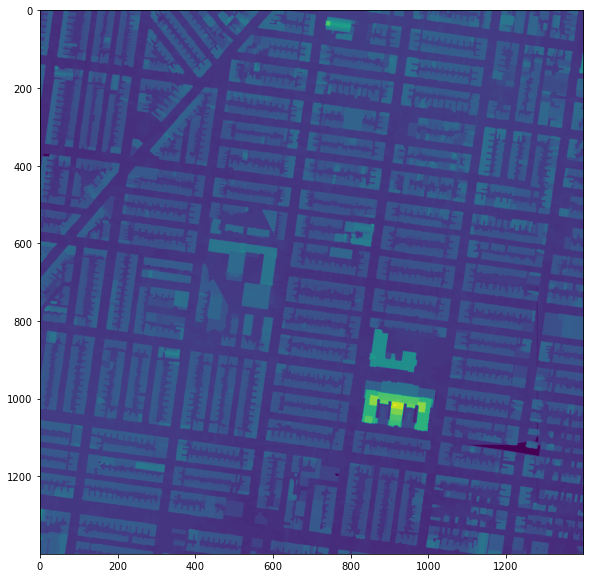

In [26]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.imshow(lu_img)
plt.show()

In [27]:
## This script is used to calculate different types of SVFs based on DSM
## modified based on UMEP without GUI, without considering the vegetation
## For consideration of the vegetation check the version of svfsCalculator_veg.py

## First created Dec 21, 2020, using GPU to accelearate the computation of SVF based
## on the digital surface model. 
## By Xiaojiang Li, Temple University, PA


def annulus_weight(altitude, aziinterval):
    '''assign different weight to different annulus'''
    n = 90.
    steprad = (360./aziinterval) * (np.pi/180.)
    annulus = 91.-altitude
    w = (1./(2.*np.pi)) * np.sin(np.pi / (2.*n)) * np.sin((np.pi * (2. * annulus - 1.)) / (2. * n))
    weight = steprad * w
    
    return weight
    

def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    

In [28]:

# def shadowingfunctionglobalradiation(a, azimuth, altitude, scale, dlg, forsvf):
def shadowingfunctionglobalradiation(a, azimuth, altitude, scale, forsvf):
    import numpy as np
    
    #%This m.file calculates shadows on a DEM
    #% conversion
    degrees = np.pi/180.
    if azimuth == 0.0:
        azimuth = 0.000000000001
    azimuth = np.dot(azimuth, degrees)
    altitude = np.dot(altitude, degrees)
    
    #% measure the size of the image
    sizex = a.shape[0]
    sizey = a.shape[1]
    if forsvf == 0:
        barstep = np.max([sizex, sizey])

    #% initialise parameters
    f = a
    dx = 0.
    dy = 0.
    dz = 0.
    temp = np.zeros((sizex, sizey))
    index = 1.
    #% other loop parameters
    amaxvalue = a.max()
    pibyfour = np.pi/4.
    threetimespibyfour = 3.*pibyfour
    fivetimespibyfour = 5.*pibyfour
    seventimespibyfour = 7.*pibyfour
    sinazimuth = np.sin(azimuth)
    cosazimuth = np.cos(azimuth)
    tanazimuth = np.tan(azimuth)
    signsinazimuth = np.sign(sinazimuth)
    signcosazimuth = np.sign(cosazimuth)
    dssin = np.abs((1./sinazimuth))
    dscos = np.abs((1./cosazimuth))
    tanaltitudebyscale = np.tan(altitude) / scale
    
    #% main loop
    while (amaxvalue >= dz and np.abs(dx) < sizex and np.abs(dy) < sizey):
        if (pibyfour <= azimuth and azimuth < threetimespibyfour or fivetimespibyfour <= azimuth and azimuth < seventimespibyfour):
            dy = signsinazimuth * index
            dx = -1. * signcosazimuth * np.abs(np.round(index / tanazimuth))
            ds = dssin
        else:
            dy = signsinazimuth * np.abs(np.round(index * tanazimuth))
            dx = -1. * signcosazimuth * index
            ds = dscos
        
        #% note: dx and dy represent absolute values while ds is an incremental value
        dz = ds *index * tanaltitudebyscale
        temp[0:sizex, 0:sizey] = 0.
        absdx = np.abs(dx)
        absdy = np.abs(dy)
        xc1 = (dx+absdx)/2.+1.
        xc2 = sizex+(dx-absdx)/2.
        yc1 = (dy+absdy)/2.+1.
        yc2 = sizey+(dy-absdy)/2.
        xp1 = -((dx-absdx)/2.)+1.
        xp2 = sizex-(dx+absdx)/2.
        yp1 = -((dy-absdy)/2.)+1.
        yp2 = sizey-(dy+absdy)/2.
        temp[int(xp1)-1:int(xp2), int(yp1)-1:int(yp2)] = a[int(xc1)-1:int(xc2), int(yc1)-1:int(yc2)] - dz
        # f = np.maximum(f, temp)  # bad performance in python3. Replaced with fmax
        f = np.fmax(f, temp)
        index += 1.
    
    f = f-a
    f = np.logical_not(f)
    sh = np.double(f)
    
    return sh
    

In [29]:
from pycuda.compiler import SourceModule
import pycuda
from pycuda import gpuarray
from pycuda import compiler
import pycuda.driver as cuda
import pycuda.autoinit             # PyCuda autoinit
import pycuda.driver as cuda       # PyCuda In, Out helpers
import matplotlib.pyplot as plot   # Library to plot
import matplotlib.cm as colormap   # Library to plot
import numpy                       # Fast math library
import time
import numpy as np                     # numeric python lib
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour
import scipy.ndimage as ndi            # to determine shape centrality
# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8)      # setting default size of plots


print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print ("Device #%d: %s" % (ordinal, dev.name()))
print (cuda)

1 device(s) found.
Device #0: GeForce GTX 1060 6GB
<module 'pycuda.driver' from '/home/jiang/anaconda3/envs/climategpu/lib/python3.7/site-packages/pycuda/driver.py'>


In [31]:
 #Kernel text
kernel = """
#include <math.h>

#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )
#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )
#define PI 3.1415926


//https://github.com/AlainPaillou/PyCuda_Denoise_Filters/blob/master/PyCuda_KNN_Denoise_Mono.py
// note: float is correspond to np.float32
__global__ void shadowCast(float * lattice_out, float * lattice, 
                            float azimuth, float altitude,
                            int imageW, int imageH) //int w, int h
{
    #define NLM_BLOCK_RADIUS    3
    
    //int imageW = 1320;
    //int imageH = 1320;
    
    const long int   ix = blockDim.x * blockIdx.x + threadIdx.x;
    const long int   iy = blockDim.y * blockIdx.y + threadIdx.y;
    const float  x = (float)ix  + 1.0f;
    const float  y = (float)iy  + 1.0f;
    const float limxmin = NLM_BLOCK_RADIUS + 2;
    const float limxmax = imageW - NLM_BLOCK_RADIUS - 2;
    const float limymin = NLM_BLOCK_RADIUS + 2;
    const float limymax = imageH - NLM_BLOCK_RADIUS - 2;
    
    long int index4;    
    
    if(ix>limxmin && ix<limxmax && iy>limymin && iy<limymax)
    {
        
        //Result accumulator
        float clr00 = 0.0;
        float clrIJ = 0.0;
        
        //Center of the KNN window
        index4 = x + (y * imageW);
        
        // the current pixel
        clr00 = lattice[index4];
        
        
        int rangeDist = 200;
        float betaMax = 0;
        float altitude_degree = PI*altitude/180.0;
        float theta;
        
        // convert the sun azimuth (clockwise zero at North) to theta (anticlockwise, zero at east)
        if (azimuth < 90 & azimuth > 0) {
            theta = PI*(90 - azimuth)/180.0;
        } else { //azimuth > 180 & azimuth<360
            theta = PI*(450 - azimuth)/180.0;
        }
        
        int flag = 0;
        for( float radius = 5; radius < rangeDist; radius = radius + 5)
        {   
            if (x + int(radius*cos(theta)) > limxmax | x + int(radius*cos(theta)) < limxmin | y - int(radius*sin(theta)) > limymax | y - int(radius*sin(theta)) < 0) 
            {
                break;
            }
            
            long int index2 = x + int(radius*cos(theta)) + (y - int(radius*sin(theta))) * imageW;
            clrIJ = lattice[index2];

            // building height information
            float buildH = clrIJ - clr00;
            
            float beta = atan(0.5*buildH/radius); //because the pixel resolution is 2ft, height is in ft
            
            if (betaMax > altitude_degree) 
            {
                //lattice_out[index4] = 1; //building is too high, shadow
                flag = 1;
                break;
            }
            
            if (betaMax < beta)
            {
                betaMax = beta;
            }
        }
        
        if (flag == 1) {
            lattice_out[index4] = 0; //building is too high, shadow
        } else {
            if (betaMax > altitude_degree) 
            {
                lattice_out[index4] = 0; //building is too high, shadow
            } else {
                lattice_out[index4] = 1; // not shadow
            }
        }
    }
}


"""

#Compile and get kernel function
mod = SourceModule(kernel)
print (mod)

meanfunc = mod.get_function("shadowCast")
print (meanfunc)

In [32]:
import PIL
from PIL import Image as PILImage
import rasterio as rio
import numpy
import pycuda.driver as drv
import numpy as np

def shadowCastOnGPU(im, azimuth, altitude, scale):
    
    px = numpy.array(im).astype(numpy.float32)
    
    #print ('Size:' + str(im.shape))
    #print ('Pixels:' + str (im.shape[0]*im.shape[1]))
    #print('The px.nbtyle is:', px.nbytes, px.shape)
    
    # allocate memory on the device and transfer data to GPU 
    d_px = cuda.mem_alloc(px.nbytes)
    cuda.memcpy_htod(d_px, px)
    
    height,width = im.shape
    nb_pixels = height * width
    
    # Set blocks et Grid sizes
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1
    
    #print("Test GPU ",nb_blocksX*nb_blocksY," Blocks ",nb_ThreadsX*nb_ThreadsY," Threads/Block")
    tps1 = time.time()
    
    # create empty array
    lattice_gpu = gpuarray.to_gpu(px)
    newLattice_gpu = gpuarray.empty_like(lattice_gpu)
    
    #print('type of azimuth and altitude are:', type(azimuth), type(altitude))
    # the GPU function
    KNN_Mono_GPU = mod.get_function("shadowCast")
    KNN_Mono_GPU(newLattice_gpu, d_px, \
                 np.float32(azimuth), np.float32(altitude), \
                 np.int32(width), np.int32(height), \
                 block=(nb_ThreadsX,nb_ThreadsY,1), \
                 grid=(nb_blocksX,nb_blocksY))  
    
    
    bwPx = numpy.empty_like(px)    
    bwPx = newLattice_gpu.get()
    
    bwPx = (numpy.float32(bwPx))
    pil_im = PILImage.fromarray(bwPx)
    
    return pil_im


### Get started to run for computing the SVF using shadow casting method (GPU and CPU version)

In [33]:
from osgeo import gdal
from osgeo.gdalconst import *
import os, os.path
import numpy as np
import rasterio
import time


# root = '../../data/Philadelphia'
# demfile = os.path.join(root, 'clipedDEM.tif')
# dsmfile = os.path.join(root, 'clipedDSM.tif')
demfile = r'/drive2/researchProj/gpu-climate/spatial-data/26928E223414N_dsm.tif'
# demfile = r'/drive2/thermal-env/data/miami/ground_dsm/row5-col1.tif'
dsmfile = demfile


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1)

gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(np.float)#dsm
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]

gdal_dem = gdal.Open(demfile) #dem
dem = gdal_dem.ReadAsArray().astype(np.float)


rows = dsm.shape[0]
cols = dsm.shape[1]
svf = np.zeros([rows, cols])
svfE = svf
svfS = svf
svfW = svf
svfN = svf
svfveg = np.zeros((rows, cols))
svfEveg = np.zeros((rows, cols))
svfSveg = np.zeros((rows, cols))
svfWveg = np.zeros((rows, cols))
svfNveg = np.zeros((rows, cols))
svfaveg = np.zeros((rows, cols))
svfEaveg = np.zeros((rows, cols))
svfSaveg = np.zeros((rows, cols))
svfWaveg = np.zeros((rows, cols))
svfNaveg = np.zeros((rows, cols))

# % amaxvalue
# vegmax = self.vegdem.max()
amaxvalue = dsmimg.max()
# amaxvalue = np.maximum(amaxvalue, vegmax)

shmat = np.zeros((rows, cols, 145))
vegshmat = np.zeros((rows, cols, 145))


index = int(0)
iangle = np.array([6, 18, 30, 42, 54, 66, 78, 90])
skyvaultaziint = np.array([12, 12, 15, 15, 20, 30, 60, 360])
aziinterval = np.array([30, 30, 24, 24, 18, 12, 6, 1])
azistart = np.array([0, 4, 2, 5, 8, 0, 10, 0])
annulino = np.array([0, 12, 24, 36, 48, 60, 72, 84, 90])
iazimuth = np.hstack(np.zeros((1, 145)))
# ialtitude = np.zeros((1, 145))
skyvaultaltint = np.array([6, 18, 30, 42, 54, 66, 78, 90])


for j in range(0, 8):
    for k in range(0, int(360 / skyvaultaziint[j])):
        iazimuth[index] = k * skyvaultaziint[j] + azistart[j]
        if iazimuth[index] > 360.:
            iazimuth[index] = iazimuth[index] - 360.
        index = index + 1


aziintervalaniso = np.ceil(aziinterval / 2.0)
index = int(0)

In [17]:

t0 = time.time()
#for i in np.arange(0, iangle.shape[0]-1):
for i in range(0, skyvaultaltint.shape[0]):
    for j in np.arange(0, (aziinterval[int(i)])):
        start_time_all = time.time()
        
        altitude = iangle[int(i)]
        azimuth = iazimuth[int(index)-1]
        
        start_time = time.time()
        #sh = shadowingfunctionglobalradiation(dsmimg, azimuth, altitude, scale, 1)
        sh = shadowCastOnGPU(dsmimg, meanfunc, azimuth, altitude, scale)
        if index > 144: continue
        
        shmat[:, :, index] = sh
        elapsed_time = time.time() - start_time
        
        print('You read i and j------------', i, j, altitude, azimuth, elapsed_time)
        
        start_time = time.time()
        # Calculate svfs
        for k in np.arange(annulino[int(i)]+1, (annulino[int(i+1.)])+1):
            weight = annulus_weight(k, aziinterval[i])*sh
            svf = svf + weight
            weight = annulus_weight(k, aziintervalaniso[i]) * sh
            if (azimuth >= 0) and (azimuth < 180):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfE = svfE + weight
            if (azimuth >= 90) and (azimuth < 270):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfS = svfS + weight
            if (azimuth >= 180) and (azimuth < 360):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfW = svfW + weight
            if (azimuth >= 270) or (azimuth < 90):
                # weight = self.annulus_weight(k, aziintervalaniso[i])*sh
                svfN = svfN + weight
        
        index += 1
        elapsed_time = time.time() - start_time
        #print('The second part time is:', elapsed_time)
        
        elapsed_time = time.time() - start_time_all
        #print('The total time consumes is:', elapsed_time)
t2 = time.time()


print('The total time is:', t2 - t0)



You read i and j------------ 0 0 6 0.0 0.4673283100128174
You read i and j------------ 0 1 6 0.0 0.053838491439819336
You read i and j------------ 0 2 6 12.0 0.054344892501831055
You read i and j------------ 0 3 6 24.0 0.05159950256347656
You read i and j------------ 0 4 6 36.0 0.05094718933105469
You read i and j------------ 0 5 6 48.0 0.050705909729003906
You read i and j------------ 0 6 6 60.0 0.050750732421875
You read i and j------------ 0 7 6 72.0 0.05173611640930176
You read i and j------------ 0 8 6 84.0 0.05309867858886719
You read i and j------------ 0 9 6 96.0 0.0556032657623291
You read i and j------------ 0 10 6 108.0 0.05297970771789551
You read i and j------------ 0 11 6 120.0 0.05108523368835449
You read i and j------------ 0 12 6 132.0 0.05035543441772461
You read i and j------------ 0 13 6 144.0 0.05173468589782715
You read i and j------------ 0 14 6 156.0 0.05136609077453613
You read i and j------------ 0 15 6 168.0 0.05114293098449707
You read i and j------------ 0 

You read i and j------------ 5 6 66 150.0 0.06155824661254883
You read i and j------------ 5 7 66 180.0 0.06251907348632812
You read i and j------------ 5 8 66 210.0 0.0616755485534668
You read i and j------------ 5 9 66 240.0 0.06139492988586426
You read i and j------------ 5 10 66 270.0 0.06386446952819824
You read i and j------------ 5 11 66 300.0 0.061537742614746094
You read i and j------------ 6 0 78 330.0 0.062476158142089844
You read i and j------------ 6 1 78 10.0 0.06307411193847656
You read i and j------------ 6 2 78 70.0 0.06195521354675293
You read i and j------------ 6 3 78 130.0 0.0615537166595459
You read i and j------------ 6 4 78 190.0 0.062192678451538086
You read i and j------------ 6 5 78 250.0 0.06135249137878418
You read i and j------------ 7 0 90 310.0 0.06183791160583496
The total time is: 35.607059478759766


In [18]:
dsmimg.shape

(1320, 1320)

In [19]:
svfS = svfS + 3.0459e-004
svfW = svfW + 3.0459e-004
# % Last azimuth is 90. Hence, manual add of last annuli for svfS and SVFW
# %Forcing svf not be greater than 1 (some MATLAB crazyness)
svf[(svf > 1.)] = 1.
svfE[(svfE > 1.)] = 1.
svfS[(svfS > 1.)] = 1.
svfW[(svfW > 1.)] = 1.
svfN[(svfN > 1.)] = 1.


svfresult = {'svf': svf, 'svfE': svfE, 'svfS': svfS, 'svfW': svfW, 'svfN': svfN,
             'svfveg': svfveg, 'svfEveg': svfEveg, 'svfSveg': svfSveg, 'svfWveg': svfWveg,
             'svfNveg': svfNveg, 'svfaveg': svfaveg, 'svfEaveg': svfEaveg, 'svfSaveg': svfSaveg,
             'svfWaveg': svfWaveg, 'svfNaveg': svfNaveg, 'shmat': shmat,'vegshmat': vegshmat}


svffile = 'svf2.tif'
svfWfile = 'svfW2.tif'
svfNfile = 'svfN2.tif'
saverasternd(gdal_dsm, svffile, svf)
saverasternd(gdal_dsm, svfWfile, svfW)
saverasternd(gdal_dsm, svfNfile, svfN)


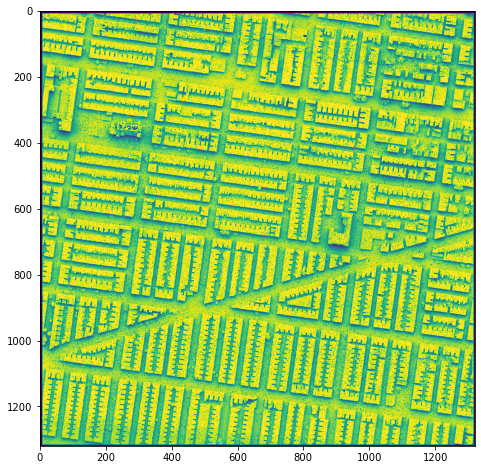

In [20]:
from matplotlib import pyplot as plt

plt.imshow(svfN)
plt.show()

In [48]:
altitude = 10
azimuth = 40

### Compare the shadow casting method using both the GPU based method and shadow casting method

The time elapsed is: 0.04846549034118652


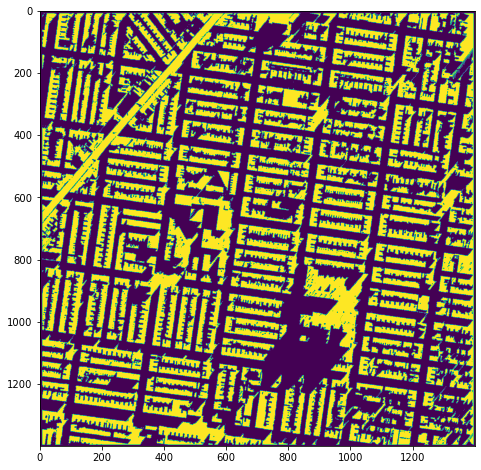

In [49]:
demfile = r'/drive2/researchProj/gpu-climate/spatial-data/ground_dsm/26981E233974N.tif'
demfile = r'/drive2/thermal-env/data/philadelphia/tiles1000/row40-col24.tif'

# demfile = r'/drive2/thermal-env/data/miami/ground_dsm/row4-col5.tif'
dem_dataset = rio.open(demfile)
im = dem_dataset.read(1)

t1 = time.time()
res = shadowCastOnGPU(im, azimuth, float(altitude), float(scale))
t2 = time.time()
print('The time elapsed is:', t2-t1)


plt.imshow(np.asarray(res))
plt.show()

The time elapsed is: 1.0437166690826416


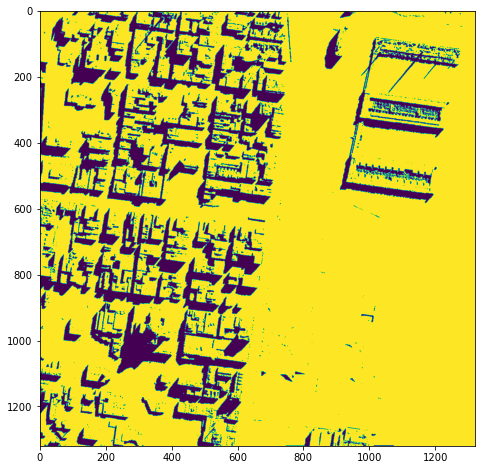

In [23]:
# azimuth = 20.0
t1 = time.time()

sh = shadowingfunctionglobalradiation(im, azimuth, altitude, scale, 1)
t2 = time.time()
print('The time elapsed is:', t2-t1)

plt.imshow(sh)
plt.show()


### A more GPU enabled implementation of the shadow casting

In [24]:
### For the CPU has no mod, GPU need to have the mod
def gvf_2018a_gpu(mod, wallsun, walls, buildings, scale, shadow, first, second, 
              dirwalls, Tg, Tgwall, Ta, emis_grid, ewall, alb_grid, SBC, 
              albedo_b, rows, cols, Twater, lc_grid, landcover):    
    
    import numpy as np
    
    sunwall = (wallsun / walls * buildings) == 1
    aspect = dirwalls*np.pi/180
    
    
    walls = numpy.array(walls).astype(numpy.float32)
    buildings = numpy.array(buildings).astype(numpy.float32)
    shadow = numpy.array(shadow).astype(numpy.float32) # the trunk 
    sunwall = numpy.array(sunwall).astype(numpy.float32)
    aspect = numpy.array(aspect).astype(numpy.float32)
    Tg = numpy.array(Tg).astype(numpy.float32)
    emis_grid = numpy.array(emis_grid).astype(numpy.float32)
    alb_grid = numpy.array(alb_grid).astype(numpy.float32)
    lc_grid = numpy.array(lc_grid).astype(numpy.float32)
    
    # allocate memory on the device and transfer data to GPU 
    walls_px = cuda.mem_alloc(walls.nbytes)
    buildings_px = cuda.mem_alloc(buildings.nbytes)
    shadow_px = cuda.mem_alloc(shadow.nbytes)
    sunwall_px = cuda.mem_alloc(sunwall.nbytes)
    aspect_px = cuda.mem_alloc(aspect.nbytes)
    Tg_px = cuda.mem_alloc(Tg.nbytes)
    emis_grid_px = cuda.mem_alloc(emis_grid.nbytes)
    alb_grid_px = cuda.mem_alloc(alb_grid.nbytes)
    lc_grid_px = cuda.mem_alloc(lc_grid.nbytes)
    
    cuda.memcpy_htod(walls_px, walls)
    cuda.memcpy_htod(buildings_px, buildings)
    cuda.memcpy_htod(shadow_px, shadow)
    cuda.memcpy_htod(sunwall_px, sunwall)
    cuda.memcpy_htod(aspect_px, aspect)
    cuda.memcpy_htod(Tg_px, Tg)
    cuda.memcpy_htod(emis_grid_px, emis_grid)
    cuda.memcpy_htod(alb_grid_px, alb_grid)
    cuda.memcpy_htod(lc_grid_px, lc_grid)
    
    
    height,width = walls.shape
    nb_pixels = height * width
    
    
    # Set blocks et Grid sizes
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1
    #print("Test GPU ",nb_blocksX*nb_blocksY," Blocks ",nb_ThreadsX*nb_ThreadsY," Threads/Block")

    
    #### Ground View Factors ####  
    # create empty array for saving 
    wallsun_gpu = gpuarray.to_gpu(shadow)
    
    gvfLup_Lattice_gpu = gpuarray.empty_like(wallsun_gpu) 
    gvfalb_Lattice_gpu = gpuarray.empty_like(wallsun_gpu) 
    gvfalbnosh_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    
    gvfLupE_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfLupS_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfLupW_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfLupN_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    
    gvfalbE_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfalbS_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfalbW_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfalbN_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    
    gvfalbnoshE_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfalbnoshS_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfalbnoshW_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfalbnoshN_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfSum_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    gvfNorm_Lattice_gpu = gpuarray.empty_like(wallsun_gpu)
    
    
    #print('type of azimuth and altitude are:', type(azimuth), type(altitude))
    # the GPU function
    KNN_Mono_GPU = mod.get_function("gvf_2018a_gpu")
    KNN_Mono_GPU(gvfLup_Lattice_gpu, \
                 gvfalb_Lattice_gpu, \
                 gvfalbnosh_Lattice_gpu, \
                 gvfLupE_Lattice_gpu, \
                 gvfalbE_Lattice_gpu, \
                 gvfalbnoshE_Lattice_gpu, \
                 gvfLupS_Lattice_gpu, \
                 gvfalbS_Lattice_gpu, \
                 gvfalbnoshS_Lattice_gpu, \
                 gvfLupW_Lattice_gpu, \
                 gvfalbW_Lattice_gpu, \
                 gvfalbnoshW_Lattice_gpu, \
                 gvfLupN_Lattice_gpu, \
                 gvfalbN_Lattice_gpu, \
                 gvfalbnoshN_Lattice_gpu, \
                 gvfSum_Lattice_gpu, \
                 gvfNorm_Lattice_gpu, \
                 np.float32(scale), \
                 buildings_px, \
                 shadow_px, \
                 sunwall_px, \
                 np.float32(first),\
                 np.float32(second),\
                 aspect_px, \
                 walls_px, \
                 Tg_px, \
                 np.float32(Tgwall), \
                 np.float32(Ta), \
                 emis_grid_px, \
                 np.float32(ewall), \
                 alb_grid_px, \
                 np.float32(SBC), \
                 np.float32(albedo_b), \
                 np.float32(Twater), \
                 lc_grid_px, \
                 np.float32(landcover), \
                 block=(nb_ThreadsX, nb_ThreadsY, 1), \
                 grid=(nb_blocksX, nb_blocksY))
    
    
    gvfLupPx = numpy.empty_like(walls)
    gvfLupPx = gvfLup_Lattice_gpu.get()
    
    gvfalbPx = numpy.empty_like(walls)    
    gvfalbPx = gvfalb_Lattice_gpu.get()
    
    gvfalbnoshPx = numpy.empty_like(walls)
    gvfalbnoshPx = gvfalbnosh_Lattice_gpu.get()
    
    gvfLupEPx = numpy.empty_like(walls)
    gvfLupEPx = gvfLupE_Lattice_gpu.get()
    
    gvfalbEPx = numpy.empty_like(walls)
    gvfalbEPx = gvfalbE_Lattice_gpu.get()
    
    gvfalbnoshEPx = numpy.empty_like(walls)
    gvfalbnoshEPx = gvfalbnoshE_Lattice_gpu.get()
    
    gvfLupSPx = numpy.empty_like(walls)
    gvfLupSPx = gvfLupS_Lattice_gpu.get()
    
    gvfalbSPx = numpy.empty_like(walls)
    gvfalbSPx = gvfalbS_Lattice_gpu.get()
    
    gvfalbnoshSPx = numpy.empty_like(walls)
    gvfalbnoshSPx = gvfalbnoshS_Lattice_gpu.get()
    
    gvfLupWPx = numpy.empty_like(walls)
    gvfLupWPx = gvfLupW_Lattice_gpu.get()
    
    gvfalbWPx = numpy.empty_like(walls)
    gvfalbWPx = gvfalbW_Lattice_gpu.get()
    
    gvfalbnoshWPx = numpy.empty_like(walls)
    gvfalbnoshWPx = gvfalbnoshW_Lattice_gpu.get()
    
    gvfLupNPx = numpy.empty_like(walls)
    gvfLupNPx = gvfLupN_Lattice_gpu.get()
    
    gvfalbNPx = numpy.empty_like(walls)
    gvfalbNPx = gvfalbN_Lattice_gpu.get()
    
    gvfalbnoshNPx = numpy.empty_like(walls)
    gvfalbnoshNPx = gvfalbnoshN_Lattice_gpu.get()
    
    gvfSumPx = numpy.empty_like(walls)
    gvfSumPx = gvfSum_Lattice_gpu.get()
    
    gvfNormPx = numpy.empty_like(walls)
    gvfNormPx = gvfNorm_Lattice_gpu.get()
    
    
    gvfLupPx = numpy.float32(gvfLupPx)
    gvfalbPx = numpy.float32(gvfalbPx)
    gvfalbnoshPx = numpy.float32(gvfalbnoshPx)
    gvfLupEPx = numpy.float32(gvfLupEPx)
    gvfalbEPx = numpy.float32(gvfalbEPx)
    gvfalbnoshEPx = numpy.float32(gvfalbnoshEPx)
    gvfLupSPx = numpy.float32(gvfLupSPx)
    gvfalbSPx = numpy.float32(gvfalbSPx)
    gvfalbnoshSPx = numpy.float32(gvfalbnoshSPx)
    gvfLupWPx = numpy.float32(gvfLupWPx)
    gvfalbWPx = numpy.float32(gvfalbWPx)
    gvfalbnoshWPx = numpy.float32(gvfalbnoshWPx)
    gvfLupNPx = numpy.float32(gvfLupNPx)
    gvfalbNPx = numpy.float32(gvfalbNPx)
    gvfalbnoshNPx = np.float32(gvfalbnoshNPx)
    gvfSumPx = numpy.float32(gvfSumPx)
    gvfNormPx = numpy.float32(gvfNormPx)
    
    
    return gvfLupPx, gvfalbPx, gvfalbnoshPx, gvfLupEPx, gvfalbEPx, gvfalbnoshEPx, \
            gvfLupSPx, gvfalbSPx, gvfalbnoshSPx, gvfLupWPx, gvfalbWPx, gvfalbnoshWPx, \
            gvfLupNPx, gvfalbNPx, gvfalbnoshNPx, gvfSumPx, gvfNormPx
